In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)


###################### Define vector field f(z) and z #############################
def f(x):
    m1 = 1; m2 = 1; g = 1; l1 = 1; l2 = 1
    a1 = x[:,0]/torch.sqrt(torch.tensor(g,dtype=torch.float))
    w1 = x[:,1]
    a2 = x[:,2]/torch.sqrt(torch.tensor(g,dtype=torch.float))
    w2 = x[:,3]
    beta1 = (m2*l1*w1**2*torch.sin(a2-a1)*torch.cos(a2-a1)+m2*g*torch.sin(a2)*torch.cos(a2-a1)+m2*l2*w2**2*torch.sin(a2-a1)-(m1+m2)*g*torch.sin(a1))/((m1+m2)*l1-m2*l1*torch.cos(a2-a1)**2)
    beta2 = (-m2*l2*w2**2*torch.sin(a2-a1)*torch.cos(a2-a1)+(m1+m2)*(g*torch.sin(a1)*torch.cos(a2-a1)-l1*w1**2*torch.sin(a2-a1)-g*torch.sin(a2)))/((m1+m2)*l1-m2*l1*torch.cos(a2-a1)**2)
    return torch.transpose(torch.stack([torch.sqrt(torch.tensor(g,dtype=torch.float))*w1,beta1,torch.sqrt(torch.tensor(g,dtype=torch.float))*w2,beta2]),0,1)

# z is input
input_ = torch.normal(0,1,size=(1000,4), requires_grad=True)*0.1
input_d = input_.shape[1]


###################### Define Jacobian and Hessian for tensor transformation #############################

# When computing T'(z') and even derivatives \nabla_{z'} T'(z'), we need to access the Jocobian and even hessian.
# The derivations are included in the appendix of arXiv: 2109.09721

def Jp_(f,t,inputs):
    #Jacobian, f is the vector field, t is the network that parameterizes the transformation.
    input_d = input_.shape[1]
    jac_f = batch_jacobian(f,inputs,create_graph=True)
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    jac_inv_ts = torch.inverse(jac_ts)

    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)

    # calculate J'
    Jp1 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*hess_t.permute(0,2,1,3).unsqueeze(dim=2)*f(inputs).unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=3)
    Jp2 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*jac_ts.unsqueeze(dim=2).unsqueeze(dim=3)*jac_f.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=2)
    Jp = Jp1 + Jp2
    Jp = torch.sum(torch.sum(Jp,dim=4),dim=3)
    return Jp

def hess(t, inputs):
    # Hessian
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    
    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)
    
    return hess_t
    
###################### Define Modularity Loss #############################

def off_diag(M,n_part=[2,2]):
    bs = M.shape[0]
    input_d = M.shape[1]
    assert input_d == np.sum(n_part)
    start = 0
    end = n_part[0]
    diag_loss = 0
    for i in range(len(n_part)):
        diag_loss = diag_loss + torch.sum(M[:,start:end, start:end]**2)
        start = end
        end = end + n_part[i]
    return (torch.sum(M**2) - diag_loss)/(batch_size*input_d**2)


def modularity_loss(f,t,inputs,n_part=[2,2]):
    Jp = Jp_(f,t,inputs)
    loss = off_diag(Jp,n_part=n_part)
    return loss


###################### Define Hamiltonicity Loss #############################

def hamiltonicity_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)
    input_d = inputs.shape[1]
    assert input_d % 2 ==0
    M = torch.zeros(input_d, input_d)
    half_d = int(input_d/2)
    M[:half_d, half_d:] = torch.eye(half_d)
    M[half_d:, :half_d] = -torch.eye(half_d)
    M = torch.tensor(M, dtype=torch.float, requires_grad=True)
    JMMJ = torch.matmul(Jp.permute(0,2,1), M) + torch.matmul(M, Jp)
    loss = torch.mean(JMMJ**2)
    return loss


###################### Define the network for coordinate transformation #############################

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)


class T(nn.Module):
    def __init__(self,w=200):
        super(T, self).__init__()
        self.l1 = nn.Linear(input_d,w)
        self.l2 = nn.Linear(w,w)
        self.l23 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,input_d)
    
    def forward(self, x, eps=1.0):
        bs = x.shape[0]
        f = nn.SiLU()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x23 = f(self.l23(self.x2))
        self.x3 = self.l3(self.x23)
        return x + eps*self.x3
    
    def transform_f(self, x):
        jac_ts = batch_jacobian(self.forward, x, create_graph=True)
        return torch.matmul(jac_ts, torch.unsqueeze(f(x), dim=2))

In [2]:
# Training a network to minimize Hamiltonicity loss and Modularity loss


np.random.seed(0)
torch.manual_seed(0)

t = T(w=400)
epochs = 500
switch_epoch = 250
lr_decay_epoch = 50

n_train = input_.shape[0]
batch_size = 128

lr = 1e-3
optimizer = optim.Adam(t.parameters(), lr=lr)

log = 10

losses_ham = [] # hamiltonicity
losses_mod = [] # modularity

for epoch in range(epochs):

    t.train()
    optimizer.zero_grad()
    
    choices = np.random.choice(n_train, batch_size)
    inputs = input_[choices]
    
    if epoch == switch_epoch:
        for opt_param in optimizer.param_groups:
            lr = 1e-3
            opt_param['lr'] = lr
    
    if (epoch+1) % lr_decay_epoch == 0:
        for opt_param in optimizer.param_groups:
            lr = lr * 0.5
            opt_param['lr'] = lr
    
    if epoch < switch_epoch:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_mod = float("nan")
        losses_ham.append(loss_ham.detach().numpy())
        losses_mod.append(loss_mod)
        loss = loss_ham
    else:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_mod = modularity_loss(f,t,inputs,n_part=[2,2])
        losses_ham.append(loss_ham.detach().numpy())
        losses_mod.append(loss_mod.detach().numpy())
        loss = loss_ham + loss_mod
        
    loss.backward(retain_graph=True)
    #loss.backward()
    optimizer.step()
    
    if epoch%log == 0:
        print('Epoch:  %d | Loss_ham: %.4f | Loss_mod: %.4f' %(epoch, loss_ham, loss_mod))

D:\tmp\TEMP\ipykernel_12584\609549126.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M, dtype=torch.float, requires_grad=True)


Epoch:  0 | Loss_ham: 0.7899 | Loss_mod: nan
Epoch:  10 | Loss_ham: 0.1171 | Loss_mod: nan
Epoch:  20 | Loss_ham: 0.0676 | Loss_mod: nan
Epoch:  30 | Loss_ham: 0.0900 | Loss_mod: nan
Epoch:  40 | Loss_ham: 0.0724 | Loss_mod: nan
Epoch:  50 | Loss_ham: 0.0591 | Loss_mod: nan
Epoch:  60 | Loss_ham: 0.0603 | Loss_mod: nan
Epoch:  70 | Loss_ham: 0.0467 | Loss_mod: nan
Epoch:  80 | Loss_ham: 0.0378 | Loss_mod: nan
Epoch:  90 | Loss_ham: 0.0216 | Loss_mod: nan
Epoch:  100 | Loss_ham: 0.0133 | Loss_mod: nan
Epoch:  110 | Loss_ham: 0.0059 | Loss_mod: nan
Epoch:  120 | Loss_ham: 0.0023 | Loss_mod: nan
Epoch:  130 | Loss_ham: 0.0014 | Loss_mod: nan
Epoch:  140 | Loss_ham: 0.0016 | Loss_mod: nan
Epoch:  150 | Loss_ham: 0.0016 | Loss_mod: nan
Epoch:  160 | Loss_ham: 0.0014 | Loss_mod: nan
Epoch:  170 | Loss_ham: 0.0010 | Loss_mod: nan
Epoch:  180 | Loss_ham: 0.0014 | Loss_mod: nan
Epoch:  190 | Loss_ham: 0.0015 | Loss_mod: nan
Epoch:  200 | Loss_ham: 0.0011 | Loss_mod: nan
Epoch:  210 | Loss_ham: 

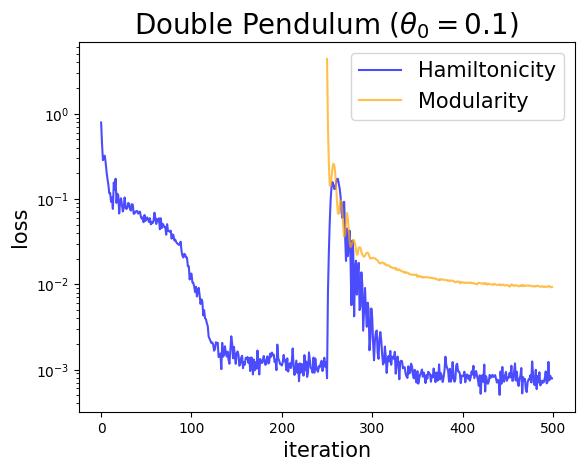

In [13]:
plt.plot(np.arange(epochs), losses_ham, color="blue",alpha=0.7)
plt.plot(np.arange(epochs), losses_mod, color="orange",alpha=0.7)
plt.xlabel("iteration",fontsize=15)
plt.ylabel("loss",fontsize=15)
plt.title("Double Pendulum "+r"$(\theta_0=0.1)$",fontsize=20)
plt.yscale('log')
plt.legend(["Hamiltonicity", "Modularity"], fontsize=15)

In [14]:
###################### Define the Schwarzchild metric tensor #############################
def g(x_):
    bs = x_.shape[0]
    t = x_[:,0]
    x = x_[:,1]
    y = x_[:,2]
    z = x_[:,3]
    r = torch.sqrt(x**2+y**2+z**2)
    stack1 = torch.stack([torch.ones(bs,)-1/r, torch.zeros(bs,), torch.zeros(bs,), torch.zeros(bs,)])
    stack2 = torch.stack([torch.zeros(bs,), -(1+x**2/((r-1)*r**2)), -x*y/((r-1)*r**2), -x*z/((r-1)*r**2)])
    stack3 = torch.stack([torch.zeros(bs,), -x*y/((r-1)*r**2), -(1+y**2/((r-1)*r**2)), -y*z/((r-1)*r**2)])
    stack4 = torch.stack([torch.zeros(bs,), -x*z/((r-1)*r**2), -y*z/((r-1)*r**2), -(1+z**2/((r-1)*r**2))])
    gs = torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
    return gs


###################### Define Euclidean Loss #############################

def euclidean_loss(g,t,inputs):
    gp = t.transform_g(inputs)
    bs = gp.shape[0]
    minkowski_metric = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=2) * torch.unsqueeze(torch.diag(torch.tensor([-1.,-1.,-1.], dtype=torch.float, requires_grad=True)), dim=0)
    return torch.mean((gp[:,1:,1:]-minkowski_metric)**2)


###################### Define The Network for Coordinate Tranformation #############################

class T(nn.Module):
    def __init__(self,w=256):
        super(T, self).__init__()
        self.l1 = nn.Linear(1,w)
        #self.l1 = nn.Linear(input_d,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,2)
    
    def forward(self, x, eps=1.0):
        bs = x.shape[0]
        #f = nn.ReLU()
        f = nn.Tanh()
        #self.x1 = f(self.l1(x[:,1:]))
        self.t = x[:,0]
        self.r = torch.unsqueeze(torch.sqrt(x[:,1]**2+x[:,2]**2+x[:,3]**2),dim=1)
        #self.tr = torch.transpose(torch.stack([self.t,self.r]),1,0)
        self.x1 = f(self.l1(self.r))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        self.out_t = self.x3[:,0]
        self.out_r = self.x3[:,1]
        self.out_x = x[:,1]/self.r[:,0]*self.out_r
        self.out_y = x[:,2]/self.r[:,0]*self.out_r
        self.out_z = x[:,3]/self.r[:,0]*self.out_r
        self.out = torch.transpose(torch.stack([self.out_t,self.out_x,self.out_y,self.out_z]),1,0)
        return x + eps*self.out
    
    
    def transform_g(self, x):
        jac_t = torch.autograd.functional.jacobian(self.forward,x,create_graph=True)
        jac_ts = []
        for i in range(jac_t.shape[0]):
            jac_ts.append(jac_t[i,:,i,:])

        jac_ts = torch.stack(jac_ts)
        jac_inv_ts = torch.inverse(jac_ts)
        return torch.matmul(torch.matmul(jac_inv_ts.permute(0,2,1), g(x)),jac_inv_ts)

In [15]:
# Training a network to minimize the Euclidean loss

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

def g(x_):
    bs = x_.shape[0]
    t = x_[:,0]
    #a = t
    a = torch.ones_like(t)
    x = x_[:,1]
    y = x_[:,2]
    z = x_[:,3]
    r = torch.sqrt(x**2+y**2+z**2)
    stack1 = torch.stack([torch.ones(bs,)-1/r, torch.zeros(bs,), torch.zeros(bs,), torch.zeros(bs,)])
    stack2 = torch.stack([torch.zeros(bs,), -(1+x**2/((r-1)*r**2)), -x*y/((r-1)*r**2), -x*z/((r-1)*r**2)])
    stack3 = torch.stack([torch.zeros(bs,), -x*y/((r-1)*r**2), -(1+y**2/((r-1)*r**2)), -y*z/((r-1)*r**2)])
    stack4 = torch.stack([torch.zeros(bs,), -x*z/((r-1)*r**2), -y*z/((r-1)*r**2), -(1+z**2/((r-1)*r**2))])
    gs = torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
    return gs


W = torch.normal(0,1,size=(1000,4),requires_grad=True)
input_ = torch.empty(1000,4, requires_grad=False)
input_[:,0] = (torch.rand(1000, requires_grad=True)-0.5)*3.0 + 1.5
rs = torch.linspace(1.1,2.5,steps=1001)[:1000]**2
input_[:,1:] = W[:,1:]/torch.norm(W[:,1:], dim=1, keepdim=True)*torch.unsqueeze(rs, dim=1)


input_d = input_.shape[1]


t = T(w=400)
epochs = 1000
switch_epoch = 200

n_train = input_.shape[0]
batch_size = 64

lr = 5e-3
optimizer = optim.Adam(t.parameters(), lr=lr)

log = 10

losses = []

for epoch in range(epochs):
    
    if (epoch) % 1000 == 0:
        lr = lr * 0.2
        optimizer = optim.Adam(t.parameters(), lr=lr)

    t.train()
    optimizer.zero_grad()

    choices = np.random.choice(n_train, batch_size)
    inputs = input_[choices]


    loss = euclidean_loss(g,t,inputs)
    losses.append(loss.detach().numpy())
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch%log == 0:
        print('Epoch:  %d | loss: %.8f ' %(epoch,loss))

Epoch:  0 | loss: 0.10227069 
Epoch:  10 | loss: 0.04519480 
Epoch:  20 | loss: 0.02109207 
Epoch:  30 | loss: 0.01513218 
Epoch:  40 | loss: 0.01449296 
Epoch:  50 | loss: 0.00947515 
Epoch:  60 | loss: 0.00615279 
Epoch:  70 | loss: 0.00450062 
Epoch:  80 | loss: 0.00349550 
Epoch:  90 | loss: 0.00168047 
Epoch:  100 | loss: 0.00383720 
Epoch:  110 | loss: 0.00115025 
Epoch:  120 | loss: 0.00104561 
Epoch:  130 | loss: 0.00076378 
Epoch:  140 | loss: 0.00126898 
Epoch:  150 | loss: 0.00194013 
Epoch:  160 | loss: 0.00051478 
Epoch:  170 | loss: 0.00015242 
Epoch:  180 | loss: 0.00044413 
Epoch:  190 | loss: 0.00023591 
Epoch:  200 | loss: 0.00019732 
Epoch:  210 | loss: 0.00015808 
Epoch:  220 | loss: 0.00011724 
Epoch:  230 | loss: 0.00021574 
Epoch:  240 | loss: 0.00023123 
Epoch:  250 | loss: 0.00011733 
Epoch:  260 | loss: 0.00011162 
Epoch:  270 | loss: 0.00008620 
Epoch:  280 | loss: 0.00012281 
Epoch:  290 | loss: 0.00009131 
Epoch:  300 | loss: 0.00014454 
Epoch:  310 | loss:

Text(0, 0.5, 'Loss')

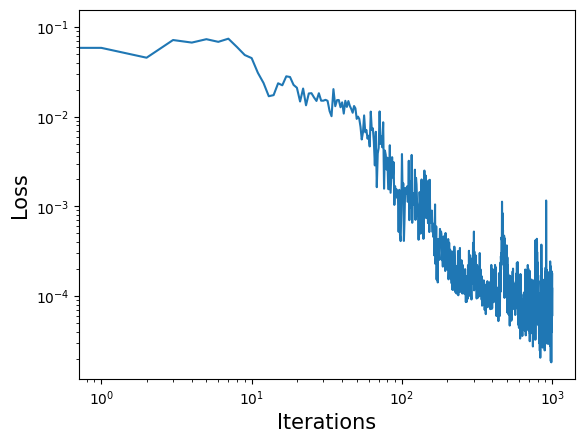

In [16]:
plt.plot(np.arange(epochs), losses)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations',fontsize=15)
plt.ylabel('Loss',fontsize=15)

Text(0.5, 1.0, 'GP coordinate of Schwarzschild')

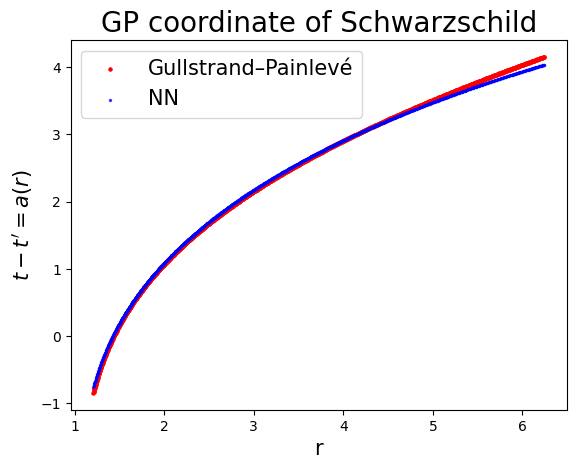

In [17]:
# Compared Learned t'=t+f(r) with ground truth

xp = t(input_)
tps = xp[:,0].detach().numpy()
rs = torch.norm(input_[:,1:], dim=1).detach().numpy()
rps = torch.norm(xp[:,1:], dim=1).detach().numpy()
tdiff = (input_[:,0] - 1*xp[:,0]).detach().numpy()

a_true = 2*np.sqrt(rs) - np.log((np.sqrt(rs)+1)/(np.sqrt(rs)-1))

shift = np.mean(tdiff) - np.mean(a_true)

plt.scatter(rs, a_true, s=5,color="red")
plt.scatter(rs, tdiff-shift, s=2, alpha=0.7, color="blue")
plt.legend(["Gullstrand–Painlevé","NN"],fontsize=15)
plt.xlabel("r", fontsize=15)
#plt.text(3.5,-1.5,r"$a(u)=-2u+ln(\frac{u+1}{u-1})$",color="red",fontsize=15)
#plt.text(5,-2.5,r"$u=\sqrt{\frac{r}{2M}}$",color="red",fontsize=15)
plt.ylabel(r"$t-t' = a(r)$", fontsize=15)
plt.title("GP coordinate of Schwarzschild",fontsize=20)